In [1]:

!pip install keras==2.3.1
!pip install tensorflow==2.1.0

     |████████████████████████████████| 377 kB 8.6 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 5.9 MB/s  eta 0:00:01
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 421.8 MB 20 kB/s  eta 0:00:011    |███▏                            | 41.1 MB 1.5 MB/s eta 0:04:20��██▋     | 351.4 MB 80.9 MB/s eta 0:00:01
     |████████████████████████████████| 448 kB 65.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 60.5 MB/s eta 0:00:01
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7539 sha256=fc1fbc4ad316c9107a0f877c10825671a39c95aabf2232e1688db0c02b9be207
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninst

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import glob
import os

from keras import Input
from keras.applications import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from keras.layers import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam


import random
from numpy import asarray
from itertools import repeat

import imageio
from imageio import imread
from PIL import Image
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

print("Tensorflow version " + tf.__version__)
print("Keras version " + tf.keras.__version__)

Using TensorFlow backend.


Tensorflow version 2.1.0
Keras version 2.2.4-tf


In [5]:
# data path
TRAIN_PATH = r'../input/kermany2018/OCT2017 /train/'
VAL_PATH = r'../input/kermany2018/OCT2017 /val/'
TEST_PATH = r'../input/kermany2018/OCT2017 /test/'
data_path = TRAIN_PATH

epochs = 2000

# batch size equals to 8 (due to RAM limits)
batch_size = 8

# define the shape of low resolution image (LR) 
low_resolution_shape = (64, 64, 3)

# define the shape of high resolution image (HR) 
high_resolution_shape = (256, 256, 3)

# optimizer for discriminator, generator 
common_optimizer = Adam(0.0002, 0.5)

# use seed for reproducible results
SEED = 2020 
tf.random.set_seed(SEED)

## III. Data

Load data, process data, EDA

In [7]:
def get_train_images(data_path):

    CLASSES = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    image_list = []

    for class_type in CLASSES:
        image_list.extend(glob.glob(data_path + class_type + '/*'))
    
    return image_list    

In [8]:
def find_img_dims(image_list):
    
    min_size = []
    max_size = []
    
    for i in range(len(image_list)):
        im = Image.open(image_list[i])
        min_size.append(min(im.size))
        max_size.append(max(im.size))
    
    return min(min_size), max(max_size)

In [10]:
# get min/max image sizes

image_list = get_train_images(data_path)
min_size, max_size = find_img_dims(image_list)
print('The min and max image dims are {} and {} respectively.'
      .format(min_size, max_size))

The min and max image dims are 384 and 1536 respectively.


In [11]:
def compute_psnr(original_image, generated_image):
    
    original_image = tf.convert_to_tensor(original_image, dtype=tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype=tf.float32)
    psnr = tf.image.psnr(original_image, generated_image, max_val=1.0)

    return tf.math.reduce_mean(psnr, axis=None, keepdims=False, name=None)

In [12]:
def plot_psnr(psnr):
    
    psnr_means = psnr['psnr_quality']
    plt.figure(figsize=(10,8))
    plt.plot(psnr_means)    
    plt.xlabel('Epochs')
    plt.ylabel('PSNR') 
    plt.title('PSNR')

In [13]:
def compute_ssim(original_image, generated_image):
    
    original_image = tf.convert_to_tensor(original_image, dtype=tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype=tf.float32)
    ssim = tf.image.ssim(original_image, generated_image, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)

    return tf.math.reduce_mean(ssim, axis=None, keepdims=False, name=None)

In [14]:
def plot_ssim(ssim):
    
    ssim_means = ssim['ssim_quality']

    plt.figure(figsize=(10,8))
    plt.plot(ssim_means)
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.title('SSIM')

In [15]:
def plot_loss(losses):

    d_loss = losses['d_history']
    g_loss = losses['g_history']
    
   
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Loss")    
    plt.legend()

### IV C. Sampling, saving images

In [16]:
def sample_images(image_list, batch_size, high_resolution_shape, low_resolution_shape):
    
    """
    Pre-process a batch of training images
    """
    
    # image_list is the list of all images
    # ransom sample a batch of images
    images_batch = np.random.choice(image_list, size=batch_size)
    
    lr_images = []
    hr_images = []
    

    for img in images_batch:
  
        img1 = imread(img, as_gray=False, pilmode='RGB')
        #img1 = imread(img, pilmode='RGB')
        img1 = img1.astype(np.float32)
        
        # change the size     
        img1_high_resolution = imresize(img1, high_resolution_shape)
        img1_low_resolution = imresize(img1, low_resolution_shape)
                

        # do a random horizontal flip
        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)
       
        hr_images.append(img1_high_resolution)
        lr_images.append(img1_low_resolution)
        
   
    # convert lists into numpy ndarrays
    return np.array(hr_images), np.array(lr_images)    

In [22]:
def save_images(original_image, lr_image, sr_image, path):
    
    """
    Save LR, HR (original) and generated SR
    images in one panel 
    """
    
    fig, ax = plt.subplots(1,3, figsize=(10, 6))

    images = [original_image, lr_image, sr_image]
    titles = ['HR', 'LR','GAN generated']

    for idx,img in enumerate(images):
        # (X + 1)/2 to scale back from [-1,1] to [0,1]
        ax[idx].imshow((img + 1)/2.0, cmap='gray')
        ax[idx].axis("off")
    for idx, title in enumerate(titles):    
        ax[idx].set_title('{}'.format(title))
        
    plt.savefig(path)    

In [23]:
def residual_block(x):

    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Add()([res, x])
    
    return res

In [24]:
def build_generator():
    
    # use 16 residual blocks in generator
    residual_blocks = 16
    momentum = 0.8
    
    # input LR dimension: 4x downsample of HR
    input_shape = (64, 64, 3)
    
    # input for the generator
    input_layer = Input(shape=input_shape)
    
    # pre-residual block: conv layer before residual blocks 
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)
    
    # add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)
    
    # post-residual block: conv and batch-norm layer after residual blocks
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)
    
    # take the sum of pre-residual block(gen1) and post-residual block(gen2)
    gen3 = Add()([gen2, gen1])
    
    # upsampling
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    
    # upsampling
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    
    # conv layer at the output
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)
    
    # model 
    model = Model(inputs=[input_layer], outputs=[output], name='generator')

    return model

In [25]:
generator = build_generator()

### V 2. Discriminator

In [26]:
def build_discriminator():
    
    # define hyperparameters
    leakyrelu_alpha = 0.2
    momentum = 0.8
    
    # the input is the HR shape
    input_shape = (256, 256, 3)
    
    # input layer for discriminator
    input_layer = Input(shape=input_shape)
    
    # 8 convolutional layers with batch normalization  
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)
    
    # fully connected layer 
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)
    
    # last fully connected layer - for classification 
    output = Dense(units=1, activation='sigmoid')(dis9)   
    
    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    
    return model

In [33]:
discriminator = build_discriminator()
discriminator.trainable = True
discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

### V 3. VGG19 Feature Extractor 

In [32]:
VGG19_base = VGG19(weights="imagenet")

574717952/574710816 [==============================] - 13s 0us/step


In [34]:
def build_VGG19():
    
    input_shape = (256, 256, 3)
    VGG19_base.outputs = [VGG19_base.get_layer('block5_conv2').output]
    input_layer = Input(shape=input_shape)
    features = VGG19_base(input_layer)
    model = Model(inputs=[input_layer], outputs=[features])
    
    return model

In [35]:
fe_model = build_VGG19()
fe_model.trainable = False
fe_model.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

In [36]:
def build_adversarial_model(generator, discriminator, feature_extractor):
    
    # input layer for high-resolution images
    input_high_resolution = Input(shape=high_resolution_shape)

    # input layer for low-resolution images
    input_low_resolution = Input(shape=low_resolution_shape)

    # generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator(input_low_resolution)

    # extract feature maps from generated images
    features = feature_extractor(generated_high_resolution_images)
    
    # make a discriminator non-trainable 
    discriminator.trainable = False
    discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

    # discriminator will give us a probability estimation for the generated high-resolution images
    probs = discriminator(generated_high_resolution_images)

    # create and compile 
    adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
    adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)
    
    return adversarial_model


In [37]:
adversarial_model = build_adversarial_model(generator, discriminator, fe_model)

## VI. Training 


In [38]:
# initialize 

losses = {"d_history":[], "g_history":[]}
psnr = {'psnr_quality': []}
ssim = {'ssim_quality': []}

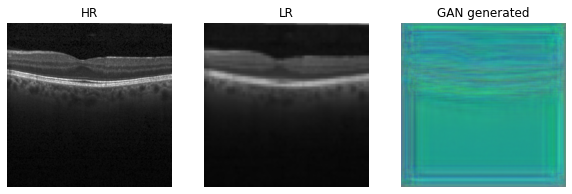

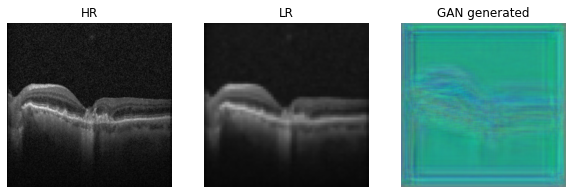

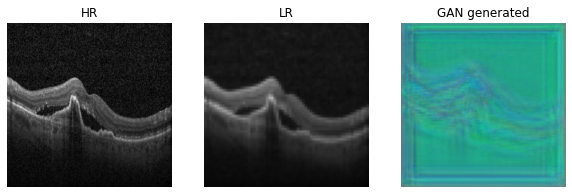

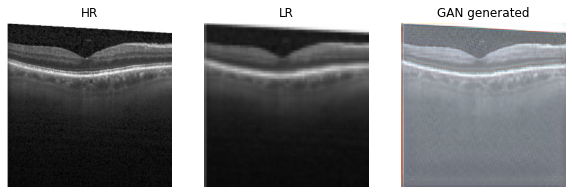

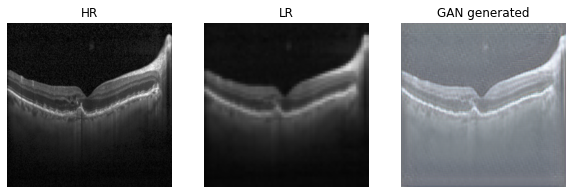

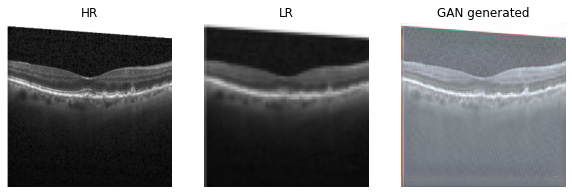

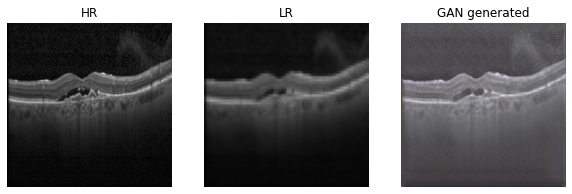

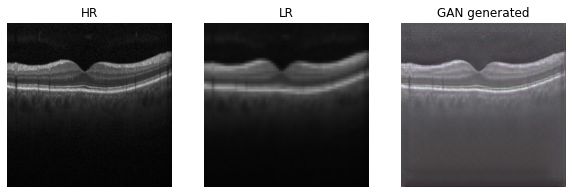

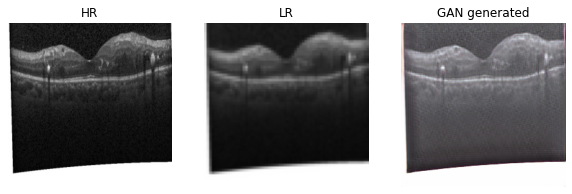

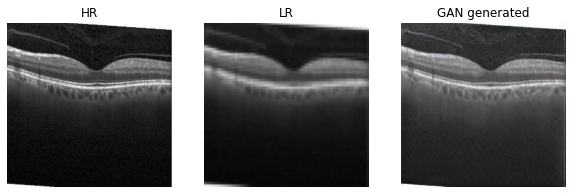

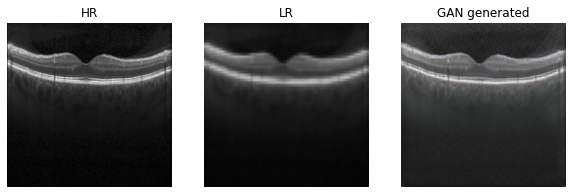

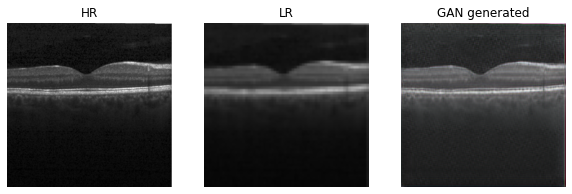

In [39]:
# training loop

for epoch in range(epochs):

    d_history = []
    g_history = []
    
    image_list = get_train_images(data_path)
    
    """
    Train the discriminator network
    """
    
    hr_images, lr_images = sample_images(image_list, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)
    
    
    # normalize the images
    hr_images = hr_images / 127.5 - 1.
    lr_images = lr_images / 127.5 - 1.
    
    # generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator.predict(lr_images)
    
    # generate a batch of true and fake labels 
    real_labels = np.ones((batch_size, 16, 16, 1))
    fake_labels = np.zeros((batch_size, 16, 16, 1))
    
 
    d_loss_real = discriminator.train_on_batch(hr_images, real_labels)
    d_loss_real =  np.mean(d_loss_real)
    d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)
    d_loss_fake =  np.mean(d_loss_fake)
    
    # calculate total loss of discriminator as average loss on true and fake labels
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    losses['d_history'].append(d_loss)
   

    """
        Train the generator network
    """
      
    # sample a batch of images    
    hr_images, lr_images = sample_images(image_list, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)
    
    
    # normalize the images
    hr_images = hr_images / 127.5 - 1.
    lr_images = lr_images / 127.5 - 1.
    
    
    
    # extract feature maps for true high-resolution images
    image_features = fe_model.predict(hr_images)


    
    # train the generator
    g_loss = adversarial_model.train_on_batch([lr_images, hr_images],
                                               [real_labels, image_features])
    
    losses['g_history'].append(0.5 * (g_loss[1]))
    
    
    
    # calculate the psnr  
    ps = compute_psnr(hr_images, generated_high_resolution_images) 
    psnr['psnr_quality'].append(ps)
            
    # calculate the ssim 
    ss = compute_ssim(hr_images, generated_high_resolution_images)   
    ssim['ssim_quality'].append(ss)

    
  
    """
        save and print image samples
    """
    
    if epoch % 500 == 0:
        
        hr_images, lr_images = sample_images(image_list, 
                                             batch_size=batch_size,
                                             low_resolution_shape=low_resolution_shape,
                                             high_resolution_shape=high_resolution_shape)
    
    
        # normalize the images
        hr_images = hr_images / 127.5 - 1.
        lr_images = lr_images / 127.5 - 1.
    
    
        generated_images = generator.predict_on_batch(lr_images)
    
        for index, img in enumerate(generated_images):
            if index < 3:   # comment this line to display all the images
                save_images(hr_images[index], lr_images[index], img,
                            path="/kaggle/working/img_{}_{}".format(epoch, index))  

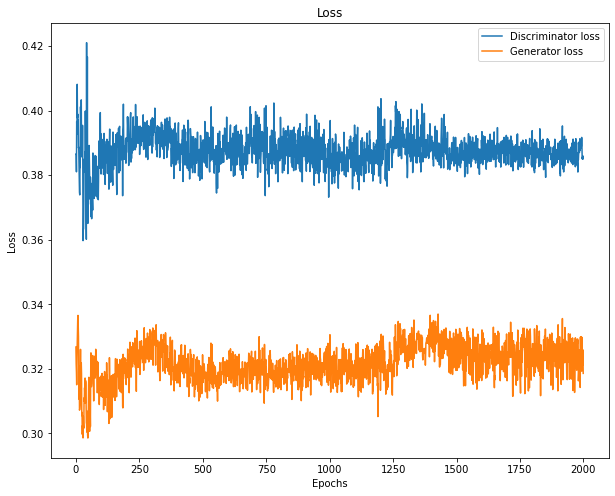

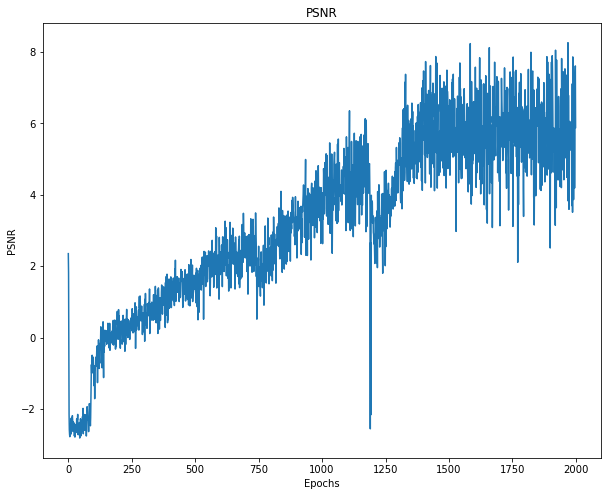

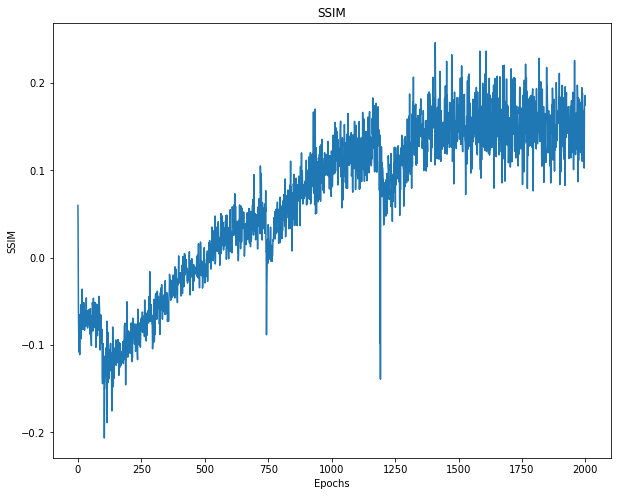

In [40]:
# plots - post training

plot_loss(losses)
plot_psnr(psnr)
plot_ssim(ssim)

In [41]:
# save model weights
# After your training is complete, save the models
generator.save('/kaggle/working/srgan_generator_full.h5')
discriminator.save('/kaggle/working/srgan_discriminator_full.h5')

# Save the model configurations
generator_json = generator.to_json()
with open("/kaggle/working/generator_config.json", "w") as json_file:
    json_file.write(generator_json)
generator.save_weights("/kaggle/working/srgan_generator.h5")
discriminator.save_weights("/kaggle/working/srgan_discriminator.h5")